In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import emoji
import sentencepiece as spm
import os
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from transformers import AutoTokenizer
import numpy as np
import fasttext
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, BatchNormalization, Conv1D, MaxPooling1D, LSTM, SimpleRNN, Bidirectional, Dense, GlobalMaxPooling1D, Dropout,GRU, Input, Dense


In [2]:
df = pd.read_csv("../data/70000correctly labled data.csv")
df = df[(df.sentiment != "Neutral") & (df.sentiment != "labels")]
df.rename(columns={"sentiment":"labels"}, inplace=True)

In [3]:
df.labels.unique()

array(['Positive', 'Negative', nan], dtype=object)

In [4]:
df.labels.value_counts()

Positive    24948
Negative    20728
Name: labels, dtype: int64

In [5]:
df_redu = df.copy()
df_redu = df_redu.sample(frac=1).reset_index(drop=True)


In [6]:
STOP_WORDS = set(
    """
ግን አንቺ አንተ እናንተ ያንተ ያንቺ የናንተ ራስህን ራስሽን ራሳችሁን
ሁሉ ኋላ በሰሞኑ አሉ በኋላ ሁኔታ በኩል አስታውቀዋል ሆነ በውስጥ
አስታውሰዋል ሆኑ ባጣም እስካሁን ሆኖም በተለይ አሳሰበ ሁል በተመለከተ
አሳስበዋል ላይ በተመሳሳይ አስፈላጊ ሌላ የተለያየ አስገነዘቡ ሌሎች የተለያዩ
አስገንዝበዋል ልዩ ተባለ አብራርተዋል መሆኑ ተገለጸ አስረድተዋል  ተገልጿል
ማለቱ ተጨማሪ እባክህ የሚገኝ ተከናወነ እባክሽ ማድረግ ችግር አንጻር ማን
ትናንት እስኪደርስ ነበረች እንኳ ሰሞኑን ነበሩ እንኳን ሲሆን ነበር እዚሁ ሲል
ነው እንደገለጹት አለ ና እንደተናገሩት ቢሆን ነገር እንዳስረዱት ብለዋል ነገሮች
እንደገና ብዙ ናት ወቅት ቦታ ናቸው እንዲሁም በርካታ አሁን እንጂ እስከ
ማለት የሚሆኑት ስለማናቸውም ውስጥ ይሆናሉ ሲባል ከሆነው ስለዚሁ ከአንድ
ያልሆነ ሳለ የነበረውን ከአንዳንድ በማናቸውም በሙሉ የሆነው ያሉ በእነዚሁ
ወር መሆናቸው ከሌሎች በዋና አንዲት ወይም
በላይ እንደ በማቀድ ለሌሎች በሆኑ ቢሆንም ጊዜና  ይሆኑበታል በሆነ አንዱ
ለዚህ ለሆነው ለነዚህ ከዚህ የሌላውን ሶስተኛ አንዳንድ ለማንኛውም የሆነ ከሁለት
የነገሩ ሰኣት አንደኛ እንዲሆን እንደነዚህ ማንኛውም ካልሆነ የሆኑት  ጋር ቢያንስ
ይህንንም እነደሆነ እነዚህን ይኸው  የማናቸውም
በሙሉም ይህችው በተለይም አንዱን የሚችለውን በነዚህ ከእነዚህ በሌላ
የዚሁ ከእነዚሁ ለዚሁ በሚገባ ለእያንዳንዱ የአንቀጹ ወደ ይህም ስለሆነ ወይ
ማናቸውንም ተብሎ እነዚህ መሆናቸውን የሆነችን ከአስር ሳይሆን ከዚያ የለውም
የማይበልጥ እንደሆነና እንዲሆኑ  በሚችሉ ብቻ ብሎ ከሌላ የሌላቸውን
ለሆነ በሌሎች ሁለቱንም በቀር ይህ በታች አንደሆነ በነሱ
ይህን የሌላ እንዲህ ከሆነ ያላቸው በነዚሁ በሚል የዚህ ይህንኑ
በእንደዚህ ቁጥር ማናቸውም ሆነው ባሉ በዚህ በስተቀር ሲሆንና
በዚህም መሆን ምንጊዜም እነዚህም በዚህና ያለ ስም
ሲኖር ከዚህም መሆኑን በሁኔታው የማያንስ እነዚህኑ ማንም ከነዚሁ
ያላቸውን እጅግ ሲሆኑ ለሆኑ ሊሆን ለማናቸውም እና ነዉ
""".split()
)

In [7]:
X = df_redu.texts.values
labels = df_redu.labels.values
encoded_labels = []
for label in labels:
    if label == "Negative":
        encoded_labels.append(0)
    else:
        encoded_labels.append(1)
y = np.array(encoded_labels)



### Data Cleaning
##### Steps Taken
- filter stop wors
- remove emojis
- remove punc and special chars
- remove ascii and numbers
- normalize mogisha characters

In [8]:
def filter_stop_words(ls):
    new_ls_stop = []
    for input in ls:
        cleaned = [w for w in input.split(" ") if not w in STOP_WORDS]
        new_ls_stop.append(" ".join(cleaned).strip())

    return new_ls_stop
    
def remove_emojis(ls):
    new_ls = []
    for input in ls:
        new_ls.append(emoji.replace_emoji(input)
)
    return new_ls
    
def remove_punc_and_special_chars(ls): 
    new_ls = []
    for text in ls:
        text = str(text)
        text = re.sub('[፣]', ' ',text)
        normalized_text = re.sub('[\!\@\#\$\%\^\«\»\&\*\(\)\…\[\]\{\}\;\“\”\›\’\‘\"\'\:\,\.\‹\/\<\>\?\\\\|\`\´\~\-\=\+\፡\።\፤\;\፦\፥\፧\፨\፠\፣]', '',text)
        new_ls.append(normalized_text)
    return new_ls

def remove_ascii_and_numbers(ls):
    new_ls = []
    for text_input in ls:
        text_input = str(text_input)
        rm_num_and_ascii=re.sub('[A-Za-z0-9]','',text_input)
        text = re.sub('[\'\u1369-\u137C\']+','',rm_num_and_ascii)
        new_ls.append(text)
    return new_ls

def normalize_char_level_missmatch(ls):
        new_ls = []
        for input_token in ls:
                input_token = str(input_token)
                rep1=re.sub('[ሃኅኃሐሓኻ]','ሀ',input_token)
                rep2=re.sub('[ሑኁዅ]','ሁ',rep1)
                rep3=re.sub('[ኂሒኺ]','ሂ',rep2)
                rep4=re.sub('[ኌሔዄ]','ሄ',rep3)
                rep5=re.sub('[ሕኅ]','ህ',rep4)
                rep6=re.sub('[ኆሖኾ]','ሆ',rep5)
                rep7=re.sub('[ሠ]','ሰ',rep6)
                rep8=re.sub('[ሡ]','ሱ',rep7)
                rep9=re.sub('[ሢ]','ሲ',rep8)
                rep10=re.sub('[ሣ]','ሳ',rep9)
                rep11=re.sub('[ሤ]','ሴ',rep10)
                rep12=re.sub('[ሥ]','ስ',rep11)
                rep13=re.sub('[ሦ]','ሶ',rep12)
                rep14=re.sub('[ዓኣዐ]','አ',rep13)
                rep15=re.sub('[ዑ]','ኡ',rep14)
                rep16=re.sub('[ዒ]','ኢ',rep15)
                rep17=re.sub('[ዔ]','ኤ',rep16)
                rep18=re.sub('[ዕ]','እ',rep17)
                rep19=re.sub('[ዖ]','ኦ',rep18)
                rep20=re.sub('[ጸ]','ፀ',rep19)
                rep21=re.sub('[ጹ]','ፁ',rep20)
                rep22=re.sub('[ጺ]','ፂ',rep21)
                rep23=re.sub('[ጻ]','ፃ',rep22)
                rep24=re.sub('[ጼ]','ፄ',rep23)
                rep25=re.sub('[ጽ]','ፅ',rep24)
                rep26=re.sub('[ጾ]','ፆ',rep25)
                #Normalizing words with Labialized Amharic characters such as በልቱዋል or  በልቱአል to  በልቷል  
                rep27=re.sub('(ሉ[ዋአ])','ሏ',rep26)
                rep28=re.sub('(ሙ[ዋአ])','ሟ',rep27)
                rep29=re.sub('(ቱ[ዋአ])','ቷ',rep28)
                rep30=re.sub('(ሩ[ዋአ])','ሯ',rep29)
                rep31=re.sub('(ሱ[ዋአ])','ሷ',rep30)
                rep32=re.sub('(ሹ[ዋአ])','ሿ',rep31)
                rep33=re.sub('(ቁ[ዋአ])','ቋ',rep32)
                rep34=re.sub('(ቡ[ዋአ])','ቧ',rep33)
                rep35=re.sub('(ቹ[ዋአ])','ቿ',rep34)
                rep36=re.sub('(ሁ[ዋአ])','ኋ',rep35)
                rep37=re.sub('(ኑ[ዋአ])','ኗ',rep36)
                rep38=re.sub('(ኙ[ዋአ])','ኟ',rep37)
                rep39=re.sub('(ኩ[ዋአ])','ኳ',rep38)
                rep40=re.sub('(ዙ[ዋአ])','ዟ',rep39)
                rep41=re.sub('(ጉ[ዋአ])','ጓ',rep40)
                rep42=re.sub('(ደ[ዋአ])','ዷ',rep41)
                rep43=re.sub('(ጡ[ዋአ])','ጧ',rep42)
                rep44=re.sub('(ጩ[ዋአ])','ጯ',rep43)
                rep45=re.sub('(ጹ[ዋአ])','ጿ',rep44)
                rep46=re.sub('(ፉ[ዋአ])','ፏ',rep45)
                rep47=re.sub('[ቊ]','ቁ',rep46) #ቁ can be written as ቊ
                rep48=re.sub('[ኵ]','ኩ',rep47) #ኩ can be also written as ኵ  
                new_ls.append(rep48)
        return new_ls

In [9]:
X = normalize_char_level_missmatch(X)
X = remove_punc_and_special_chars(X)
X = remove_ascii_and_numbers(X)
X = remove_emojis(X)
X = filter_stop_words(X)

len(X)

46553

- Spliting the data to 80/20

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Tokenizing the data (this is a very important stage and depends on the tokeinzer especiall for a langugage in amharic)
- padding the data

In [11]:
token = True
if token == True:
    tokenizer = Tokenizer(num_words=50000)
    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    vocab_size = len(tokenizer.word_index) + 1
else:
    sp = spm.SentencePieceProcessor()
    sp.Load("../embeddings/amh_sp.model")

    # sp.EncodeAsPieces(X[1])
    X_train = sp.EncodeAsIds(X_train)
    X_test = sp.EncodeAsIds(X_test)

    vocab_size = sp.GetPieceSize() + 1


maxlen = 10

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [14]:
len(X_train)

37242

In [18]:
len(X_train[:40000])

37242

In [15]:
len(X_test)

9311

### Prepartion for Trainning

- Implement early stopping

In [12]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor both validation loss and validation accuracy
    mode='min',          # stop training when the quantity monitored has stopped decreasing
    patience=5,          # number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # restore the weights from the epoch with the best value of the monitored quantity
)

- adding embeddings using fasttext

In [13]:
## fast text word embedding
word_vectors = fasttext.load_model("cc.am.100.bin")

# Define the maximum number of words to keep
max_words = 50000

# Extract the embedding matrix from the FastText model
embedding_dim = word_vectors.get_dimension()
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

### Modeling

In [19]:

# Define the deep learning models
models = [
    {
        'name': 'CNN',
        'model': Sequential([
            (Embedding(max_words + 1,
                    embedding_dim,
                    embeddings_initializer='glorot_uniform',
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False)),
            Conv1D(32, 5, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    },
    {
        'name': 'RNN',
        'model': Sequential([
            (Embedding(max_words + 1,
                    embedding_dim,
                    embeddings_initializer='glorot_uniform',
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False)),
            SimpleRNN(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
            BatchNormalization(),
            Dense(32, activation='relu'),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    },
    {
        'name': 'LSTM',
        'model': Sequential([
            (Embedding(max_words + 1,
                    embedding_dim,
                    embeddings_initializer='glorot_uniform',
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False)),
            LSTM(32, activation='relu'),
            Dense(64, activation='sigmoid'),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
            
        ])
    },
    {
        'name': 'bi-LSTM',
        'model': Sequential([
            (Embedding(max_words + 1,
                    embedding_dim,
                    embeddings_initializer='glorot_uniform',
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False)),
            Bidirectional(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), dropout=0.2, recurrent_dropout=0.2)),
            Dense(32, activation='sigmoid'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
            
        ])
    },
    {
        'name': 'GRU',
        'model': Sequential([
            (Embedding(max_words + 1,
                    embedding_dim,
                    embeddings_initializer='glorot_uniform',
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False)),
            GRU(units=32, dropout=0.2, recurrent_dropout=0.2),
            Dense(1, activation='sigmoid')           
        ])
    }

   
]



2023-05-20 16:18:36.067013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 16:18:36.178151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u01/app/oracle/product/11.2.0/xe/lib:
2023-05-20 16:18:36.178191: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-20 16:18:36.180967: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is 

In [21]:
# Compile each model
for m in models:
    m['model'].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

### Trainning

Epoch 1/80
157/157 [==============================] - 1s 4ms/step - loss: 0.3143 - accuracy: 0.8810 - val_loss: 0.5066 - val_accuracy: 0.7703
Epoch 2/80
157/157 [==============================] - 1s 4ms/step - loss: 0.2928 - accuracy: 0.8886 - val_loss: 0.5194 - val_accuracy: 0.7681
Epoch 3/80
157/157 [==============================] - 1s 4ms/step - loss: 0.2787 - accuracy: 0.8938 - val_loss: 0.5309 - val_accuracy: 0.7660
Epoch 4/80
157/157 [==============================] - 1s 4ms/step - loss: 0.2619 - accuracy: 0.9016 - val_loss: 0.5454 - val_accuracy: 0.7673
Epoch 5/80
157/157 [==============================] - 1s 4ms/step - loss: 0.2535 - accuracy: 0.9074 - val_loss: 0.5548 - val_accuracy: 0.7665
Epoch 6/80
157/157 [==============================] - 1s 4ms/step - loss: 0.2419 - accuracy: 0.9134 - val_loss: 0.5687 - val_accuracy: 0.7657
Epoch 6: early stopping
Epoch 1/80
157/157 [==============================] - 1s 6ms/step - loss: 0.5324 - accuracy: 0.7386 - val_loss: 0.5470 - val

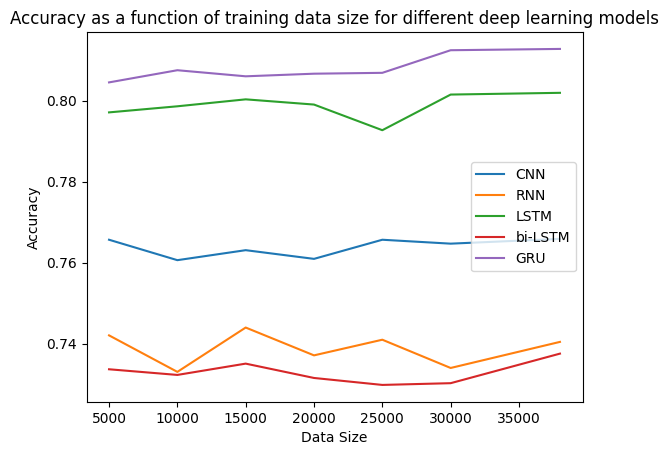

In [23]:
# Train each model with varying amounts of data
train_sizes = [5000, 10000, 15000, 20000, 25000, 30000, 38000]
histories = {m['name']: [] for m in models}
for size in train_sizes:
    for m in models:
        history = m['model'].fit(X_train[:size], y_train[:size], epochs=80, validation_data=(X_test, y_test), callbacks=[early_stopping])
        histories[m['name']].append(history)

# Plot the accuracy as a function of training data size for each model
fig, ax = plt.subplots()
for m in models:
    accuracies = []
    for i in range(len(train_sizes)):
        accuracy = histories[m['name']][i].history['val_accuracy'][-1]
        accuracies.append(accuracy)
    ax.plot(train_sizes, accuracies, label=m['name'])
ax.set_xlabel('Data Size')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as a function of training data size for different deep learning models')
ax.legend()
plt.savefig("../fig/unified_accuracy_2")
plt.show()
